In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from numba import jit, njit, vectorize
import time

## Defining functions that we need:

In [2]:
#Trial energy 1
def TrialEnergy1(alpha,omega,r1,r2):
    return 0.5*omega**2*(r1**2 + r2**2)*(1 - alpha**2) + 3*omega*alpha

@vectorize#By far the quickest of the three for vectors
def TrialEnergy1Vec(alpha,omega,r1,r2):
    #r1 = np.sqrt(x1**2 + y1**2 + z1**2)
    #r2 = np.sqrt(x2**2 + y2**2 + z2**2)
    return 0.5*omega**2*(r1**2 + r2**2)*(1 - alpha**2) + 3*omega*alpha

@jit(nopython=True)
def TrialEnergyJIT(alpha,omega,r1,r2):
    return 0.5*(omega**2)*(r1**2 + r2**2)*(1 - alpha**2) + 3*omega*alpha

#Athuga betur hvernig ég á að díla við að deila með núlli þegar Coulomb víxlverkun til staðar
@jit(nopython=True)
def TrialEnergyJITwithCoulomb(alpha,omega,x1,y1,z1,x2,y2,z2):
    r1 = np.sqrt(x1**2 + y1**2 + z1**2)
    r2 = np.sqrt(x2**2 + y2**2 + z2**2)
    r_12 = np.sqrt((x1-x2)**2 - (y1-y2)**2 - (z1-z2)**2)
    if abs(r_12) <= 1e-8:
        return 0
    else:
        return 0.5*(omega**2)*(r1**2 + r2**2)*(1 - alpha**2) + 3*omega*alpha + 1/r_12

@jit
def TrialWaveFunction1(alpha,omega,x1,y1,z1,x2,y2,z2):
    r1 = np.sqrt(x1**2 + y1**2 + z1**2)
    r2 = np.sqrt(x2**2 + y2**2 + z2**2)
    return np.exp(-alpha*omega*(r1**2 + r2**2)/2)

@jit
def TrialWaveFunction2(alpha,beta,omega,x1,y1,z1,x2,y2,z2):
    r1 = np.sqrt(x1**2 + y1**2 + z1**2)
    r2 = np.sqrt(x2**2 + y2**2 + z2**2)
    r_12 = np.sqrt((x1-x2)**2 - (y1-y2)**2 - (z1-z2)**2)
    return np.exp(-alpha*omega*(r1**2 + r2**2)/2)*np.exp(r_12/(2*(1 + beta*r_12)))

In [4]:
alpha = 1
trialEnergyTemp = TrialEnergyJIT(alpha,1,0,0)
print(trialEnergyTemp)
trialEnergyTemp = TrialEnergyJITwithCoulomb(alpha,1,1e-7,0,0,0,0,0)
print(trialEnergyTemp)

3.0
10000003.0


## Monte Carlo and Metropolis algo:

In [5]:
#Probability ratio
@jit
def ProbRatio(Rold,Rnew,alpha,omega):#Rold and Rnew as an array
    new = TrialWaveFunction1(alpha,omega,Rnew[0],Rnew[1],Rnew[2],Rnew[3],Rnew[4],Rnew[5])
    new = new**2
    old = TrialWaveFunction1(alpha,omega,Rold[0],Rold[1],Rold[2],Rold[3],Rold[4],Rold[5])
    old = old**2
    return new/old

#Metropolis part
@jit
def Metropolis(Rold,Rnew,alpha,omega):
    Acceptance = False
    probRatio = ProbRatio(Rold,Rnew,alpha,omega)
    if probRatio > 1:
        Acceptance = True
    elif np.random.random() <= probRatio:
        Acceptance = True
    else:
        Acceptance = False
    return Acceptance

In [7]:
R1 = np.array([1,1,1,1,1,1])
R2 = np.array([2,2,2,2,2,2])
alpha = 1
omega = 1
print(Metropolis(R1,R2,alpha,omega))

a = np.array([1,2,3])
print(a+1)

False
[2 3 4]


**First Monte Carlo with trial wave function 1 and without Coulomb interaction:**

ATH bæta inn variance!!!

In [20]:
#Monte Carlo part
@jit(nopython=True)
def MonteCarlo(MCCycles,omega,alpha,stepsize):
    #initalizing position randomly according to exponetial distribution
    x1 = np.random.exponential()
    y1 = np.random.exponential()
    z1 = np.random.exponential()
    x2 = np.random.exponential()
    y2 = np.random.exponential()
    z2 = np.random.exponential()
    r1 = np.sqrt(x1**2 + y1**2 + z1**2)
    r2 = np.sqrt(x2**2 + y2**2 + z2**2)
    Rold = np.array([x1,y1,z1,x2,y2,z2])
    Energy = 0
    EnergySquared = 0
    #Step size for proposed steps
    DeltaR = stepsize
    #Counter for how many steps are accepted
    CounterAccept = 0
    #looping over MC cycles
    for i in range(MCCycles):
        #looping over each position, in total 6
        for l in range(6):
            randnum = np.random.random() - 0.5#creating random number on [-0.5,0.5]
            Rnew = np.copy(Rold)
            Rnew[l] = Rold[l] + randnum*DeltaR#The proposed move for each coordinate at a time
            #Metropolis test
            Acceptance = Metropolis(Rold,Rnew,alpha,omega)
            if Acceptance:#Moving the coordinates if the move is accepted
                Rold = Rnew
                CounterAccept += 1
            r1 = np.sqrt(Rold[0]**2 + Rold[1]**2 + Rold[2]**2)
            r2 = np.sqrt(Rold[3]**2 + Rold[4]**2 + Rold[5]**2)
            EnergyTemp = TrialEnergyJIT(alpha,omega,r1,r2)
            Energy += EnergyTemp
            EnergySquared += EnergyTemp**2

    #End of MC loop
    #Analysis of relevant parameters
    AverageEnergy = Energy/MCCycles/6
    AverageEnergySquared = EnergySquared/MCCycles/6
    Variance = AverageEnergySquared - AverageEnergy**2
    
    return AverageEnergy, CounterAccept/6, Variance

**Then MC for trial wave function 1 with Coulomb interaction: ATH LAGA ÞETTA FALL!!**

In [11]:
#Monte Carlo part
@jit(nopython=True)
def MonteCarloCoulomb(MCCycles,omega,alpha,stepsize):
    #initalizing position randomly according to exponetial distribution
    x1 = np.random.exponential()
    y1 = np.random.exponential()
    z1 = np.random.exponential()
    x2 = np.random.exponential()
    y2 = np.random.exponential()
    z2 = np.random.exponential()
    r1 = np.sqrt(x1**2 + y1**2 + z1**2)
    r2 = np.sqrt(x2**2 + y2**2 + z2**2)
    Rold = np.array([x1,y1,z1,x2,y2,z2])
    Energy = TrialEnergyJITwithCoulomb(alpha,omega,x1,y1,z1,x2,y2,z2)
    print("Initial energy:",Energy)
    #Step size for proposed steps
    DeltaR = stepsize
    #Counter for how many steps are accepted
    CounterAccept = 0
    #looping over MC cycles
    for i in range(MCCycles):
        #looping over each position, in total 6
        for l in range(6):
            randnum = (1+1)*np.random.random() - 1#creating random number on [-1,1]ATH GERA FREKAR á [-0.5,0.5]
            Rnew = np.copy(Rold)
            Rnew[l] = Rold[l] + randnum*DeltaR#The proposed move for each coordinate at a time
            #Metropolis test
            Acceptance = Metropolis(Rold,Rnew,alpha,omega)
            if Acceptance:#Moving the coordinates if the move is accepted
                Rold = Rnew
                CounterAccept += 1
            r1 = np.sqrt(Rold[0]**2 + Rold[1]**2 + Rold[2]**2)
            r2 = np.sqrt(Rold[3]**2 + Rold[4]**2 + Rold[5]**2)
            if np.isnan(Energy):
                print("Error, the Energy is nan, cycle numner:",i)
                break
            Energy += TrialEnergyJITwithCoulomb(alpha,omega,Rold[0],Rold[1],Rold[2],Rold[3],Rold[4],Rold[5])

    #End of MC loop
    #Analysis of relevant parameters
    Energy = Energy/MCCycles/6
    
    return Energy, CounterAccept/6

## Trial of the MC calculations:

71829.83333333333 6.873207123021892
64617.333333333336 1.7165072822441534
59276.166666666664 0.39797493719109056
55022.0 0.03354867630279479
53197.833333333336 0.0
49920.0 0.10154226551147616
47235.0 0.35224880418301474
44840.0 0.7532466050509008
42639.0 1.147563402354324
40868.166666666664 1.695743535772733


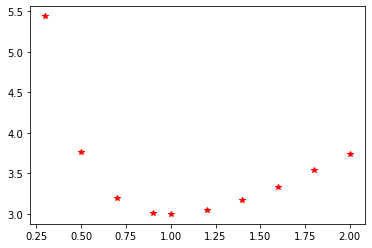

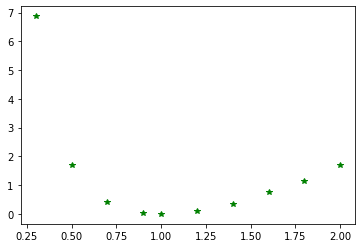

In [21]:
alpha = [0.3,0.5,0.7,0.9,1,1.2,1.4,1.6,1.8,2.0]
fig, ax = plt.subplots()
fig0, ax0 = plt.subplots()
for alphaTemp in alpha:
    Energy, Counter, Variance = MonteCarlo(100000,1,alphaTemp,3.8)
    print(Counter,Variance)
    ax.plot(alphaTemp,Energy,'r*')
    ax0.plot(alphaTemp,Variance,'g*')

**Device a way to find the optimal step length for each alpha so that acceptance rate is around 50%**

**Algorithm that takes care of finding the step size such that 50 \% acceptance rate in a brute force way:**

In [24]:
def FindStepsize(stepsize,alpha):
    MCCycles = 10000
    M = len(alpha)
    StepSize = np.zeros(M)
    counter = 0
    for i in alpha:
        StepTemp = []
        for l in stepsize:
            Energy, Counter, Variance = MonteCarlo(10000,1,i,l)
            if (Counter >= 4900) and (Counter <= 5100):
                StepTemp.append(l)
        StepSize[counter] = np.median(StepTemp)
        counter += 1
        
    return StepSize

In [27]:
#Trial
stepsize = np.arange(0,10,0.05)
alpha = np.arange(0.2,2,0.2)
print(alpha)
StepSize = FindStepsize(stepsize,alpha)

[0.2 0.4 0.6 0.8 1.  1.2 1.4 1.6 1.8]


In [28]:
print(StepSize)

[9.275 6.55  5.35  4.65  4.175 3.8   3.525 3.275 3.1  ]


500973.6666666667
501185.5
501444.8333333333
499937.0
498667.0
499560.5
498734.3333333333
501365.5
500609.1666666667


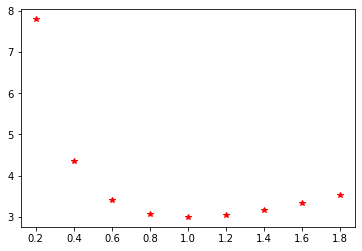

In [30]:
fig3, ax3 = plt.subplots()
for i in range(len(alpha)):
    stepTemp = StepSize[i]
    alphaTemp = alpha[i]
    Energy, Counter, Variance = MonteCarlo(1000000,1,alphaTemp,stepTemp)
    print(Counter)
    ax3.plot(alphaTemp,Energy,'r*')

# 5.c)

**First withhout Coulomb interaction:**

499491.1666666667 7.7885576110674135
499736.0 5.448679584847787
498496.5 4.35336215141765
501739.5 3.7518129675435277
498272.0 3.3990117504962547
498143.1666666667 3.1915382110710198
500134.5 3.0749866433555284
503166.8333333333 3.017040472427658
496801.1666666667 3.0000005
501537.0 3.0135986775044294
494980.6666666667 3.050324153599719
499936.3333333333 3.1038953065533605
501679.5 3.1695542353981914
504911.6666666667 3.2520284129996333
503971.5 3.3408283376184826
504652.1666666667 3.4315063941911403
505605.3333333333 3.533200268027111
502149.6666666667 3.63736427085157
Measurement took in seconds: 21.114139080047607


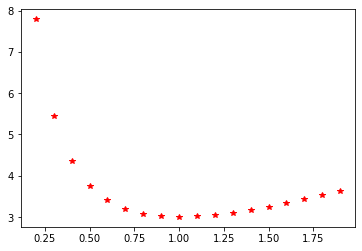

In [39]:
#Monte Carlo calculations for the first trial wave function for more number of different alpha
#first finding the optimal step size for each value of alpha
alpha1 = np.arange(0.2,2,0.1)
stepsize1 = np.arange(0,8,0.05)
StepSize1 = FindStepsize(stepsize1,alpha1)
#Then doing calculation for each alpha
fig4, ax4 = plt.subplots()
start = time.time()
for i in range(len(alpha1)):
    stepTemp = StepSize1[i]
    alphaTemp = alpha1[i]
    Energy, Counter = MonteCarlo(1000000,1,alphaTemp,stepTemp)
    print(Counter,Energy)
    ax4.plot(alphaTemp,Energy,'r*')
end = time.time()
print("Measurement took in seconds:",end-start)

**Then with Coulomb interaction:**

Initial energy: nan
Error, the Energy is nan, cycle numner: 0
Error, the Energy is nan, cycle numner: 1
Error, the Energy is nan, cycle numner: 2
Error, the Energy is nan, cycle numner: 3
Error, the Energy is nan, cycle numner: 4
Error, the Energy is nan, cycle numner: 5
Error, the Energy is nan, cycle numner: 6
Error, the Energy is nan, cycle numner: 7
Error, the Energy is nan, cycle numner: 8
Error, the Energy is nan, cycle numner: 9
Error, the Energy is nan, cycle numner: 10
Error, the Energy is nan, cycle numner: 11
Error, the Energy is nan, cycle numner: 12
Error, the Energy is nan, cycle numner: 13
Error, the Energy is nan, cycle numner: 14
Error, the Energy is nan, cycle numner: 15
Error, the Energy is nan, cycle numner: 16
Error, the Energy is nan, cycle numner: 17
Error, the Energy is nan, cycle numner: 18
Error, the Energy is nan, cycle numner: 19
Error, the Energy is nan, cycle numner: 20
Error, the Energy is nan, cycle numner: 21
Error, the Energy is nan, cycle numner: 22
E

Error, the Energy is nan, cycle numner: 48
Error, the Energy is nan, cycle numner: 49
Error, the Energy is nan, cycle numner: 50
Error, the Energy is nan, cycle numner: 51
Error, the Energy is nan, cycle numner: 52
Error, the Energy is nan, cycle numner: 53
Error, the Energy is nan, cycle numner: 54
Error, the Energy is nan, cycle numner: 55
Error, the Energy is nan, cycle numner: 56
Error, the Energy is nan, cycle numner: 57
Error, the Energy is nan, cycle numner: 58
Error, the Energy is nan, cycle numner: 59
Error, the Energy is nan, cycle numner: 60
Error, the Energy is nan, cycle numner: 61
Error, the Energy is nan, cycle numner: 62
Error, the Energy is nan, cycle numner: 63
Error, the Energy is nan, cycle numner: 64
Error, the Energy is nan, cycle numner: 65
Error, the Energy is nan, cycle numner: 66
Error, the Energy is nan, cycle numner: 67
Error, the Energy is nan, cycle numner: 68
Error, the Energy is nan, cycle numner: 69
Error, the Energy is nan, cycle numner: 70
Error, the 

Error, the Energy is nan, cycle numner: 11
Error, the Energy is nan, cycle numner: 12
Error, the Energy is nan, cycle numner: 13
Error, the Energy is nan, cycle numner: 14
Error, the Energy is nan, cycle numner: 15
Error, the Energy is nan, cycle numner: 16
Error, the Energy is nan, cycle numner: 17
Error, the Energy is nan, cycle numner: 18
Error, the Energy is nan, cycle numner: 19
Error, the Energy is nan, cycle numner: 20
Error, the Energy is nan, cycle numner: 21
Error, the Energy is nan, cycle numner: 22
Error, the Energy is nan, cycle numner: 23
Error, the Energy is nan, cycle numner: 24
Error, the Energy is nan, cycle numner: 25
Error, the Energy is nan, cycle numner: 26
Error, the Energy is nan, cycle numner: 27
Error, the Energy is nan, cycle numner: 28
Error, the Energy is nan, cycle numner: 29
Error, the Energy is nan, cycle numner: 30
Error, the Energy is nan, cycle numner: 31
Error, the Energy is nan, cycle numner: 32
Error, the Energy is nan, cycle numner: 33
Error, the 

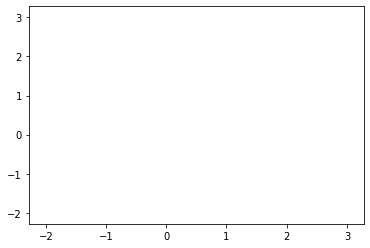

In [37]:
fig5, ax5 = plt.subplots()
for i in range(len(alpha1)):
    stepTemp = StepSize1[i]
    alphaTemp = alpha1[i]
    Energy, Counter = MonteCarloCoulomb(100,1,alphaTemp,stepTemp)
    print(Counter, Energy)
    ax5.plot(alphaTemp,Energy,'r*')

In [295]:
print(Energy)

nan
